| **Method** | **Setup** | **Pros** | **Cons** | **Cost** |
| ----- | ----- | ----- | ----- | ----- |
| Python dictionaries, CSV files, print outs | None | Easy to setup, runs in pure Python | Hard to keep track of large numbers of experiments | Free |
| [TensorBoard](https://www.tensorflow.org/tensorboard/get_started) | Minimal, install [`tensorboard`](https://pypi.org/project/tensorboard/) | Extensions built into PyTorch, widely recognized and used, easily scales. | User-experience not as nice as other options. | Free |
| [Weights & Biases Experiment Tracking](https://wandb.ai/site/experiment-tracking) | Minimal, install [`wandb`](https://docs.wandb.ai/quickstart), make an account | Incredible user experience, make experiments public, tracks almost anything. | Requires external resource outside of PyTorch. | Free for personal use | 
| [MLFlow](https://mlflow.org/) | Minimal, install `mlflow` and starting tracking | Fully open-source MLOps lifecycle management, many integrations. | Little bit harder to setup a remote tracking server than other services. | Free | 

due to its tight integration with PyTorch and widespread use, this notebook focuses on using TensorBoard to track our experiments.

In [5]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torchinfo import summary
from going_modular.going_modular import data_setup, engine
import os
import zipfile
from pathlib import Path
import requests
from torch.utils.tensorboard import SummaryWriter
from typing import Dict, List
from tqdm.auto import tqdm
from going_modular.going_modular.engine import train_step, test_step

In [2]:
# set model to MPS if available, or GPU, otherwise default to CPU
if torch.backends.mps.is_available():
    device = "mps"
    print ("MPS device found.")
elif torch.cuda.is_available():
    device = "cuda"
    print("GPU found")
else:
    device = "cpu"
    print ("Neither MPS device nor GPU found.")
    
device = "cpu"

MPS device found.


In [3]:
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
print(image_path)

# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

data/pizza_steak_sushi


In [4]:
# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# manually create transform pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

# create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x163665950>,
 ['pizza', 'steak', 'sushi'])

### why tf does this guide keep having me do everything twice. we just created the dataloaders manually and now we're gonna do it automatically. so stupid. I mean i get doing that the first time for sake of learning but i'm just tryna rip through this lesson and this is not helping. too lazy to sift through everything and make a more streamlined version of his code tho so i guess i'll just continue to copy & paste

In [5]:
# setup pre-trained weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# get transforms from weights
automatic_transforms = weights.transforms()

# create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms,
    batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x163676210>,
 ['pizza', 'steak', 'sushi'])

In [6]:
# setup model w pretrained weights & send it to device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# freeze all base layers
for param in model.features.parameters():
    param.requires_grad = False
    
# update classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
             out_features=len(class_names),
             bias=True)).to(device)

In [7]:
# Get a summary of the model
summary(model, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [8]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Previously, we've tracked our modelling experiments using multiple Python dictionaries (one for each model).

But you can imagine this could get out of hand if we were running anything more than a few experiments.

Not to worry, there's a better option!

We can use PyTorch's [`torch.utils.tensorboard.SummaryWriter()`](https://pytorch.org/docs/stable/tensorboard.html) class to save various parts of our model's training progress to file.

By default, the `SummaryWriter()` class saves various information about our model to a file set by the `log_dir` parameter. 

The default location for `log_dir` is under `runs/CURRENT_DATETIME_HOSTNAME`, where the `HOSTNAME` is the name of your computer.

But of course, you can change where your experiments are tracked (the filename is as customisable as you'd like).

The outputs of the `SummaryWriter()` are saved in [TensorBoard format](https://www.tensorflow.org/tensorboard/).

TensorBoard is a part of the TensorFlow deep learning library and is an excellent way to visualize different parts of your model.

To start tracking our modelling experiments, let's create a default `SummaryWriter()` instance.

In [23]:
# create writer w default settings
writer = SummaryWriter()

We'll get the `train()` function from [`engine.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py) and adjust it to use `writer`.

Specifically, we'll add the ability for our `train()` function to log our model's training and test loss and accuracy values.

We can do this with [`writer.add_scalars(main_tag, tag_scalar_dict)`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_scalars), where:
* `main_tag` (string) - the name for the scalars being tracked (e.g. "Accuracy")
* `tag_scalar_dict` (dict) - a dictionary of the values being tracked (e.g. `{"train_loss": 0.3454}`)
    * > **Note:** The method is called `add_scalars()` because our loss and accuracy values are generally scalars (single values).

Once we've finished tracking values, we'll call `writer.close()` to tell the `writer` to stop looking for values to track.

To start modifying `train()` we'll also import `train_step()` and `test_step()` from [`engine.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py).

In [11]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.going_modular.engine import train_step, test_step

In [24]:
# copy & edit train() function from: 
# https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        ### NEW: experiment tracking
        writer.add_scalars(main_tag="Loss",
                          tag_scalar_dict={"train_loss":train_loss,
                                          "test_loss": test_loss},
                          global_step=epoch)
        writer.add_scalars("Accuracy",
                          {"train_acc": train_acc,
                            "test_acc": test_acc},
                          epoch)
        # also legitimate way to do it
        #writer.add_scalar(tag="loss/train",
        #                  scalar_value=train_loss,
        #                  global_step=epoch)
        #writer.add_scalar(tag="loss/test",
        #                  scalar_value=test_loss,
        #                  global_step=epoch)
        #writer.add_scalar(tag="accuracy/train",
        #                  scalar_value=train_acc,
        #                  global_step=epoch)
        #writer.add_scalar(tag="accuracy/test",
        #                  scalar_value=test_acc,
        #                  global_step=epoch)
        # track the pytorch model architecture
        writer.add_graph(model=model,
                        # pass in an example input
                        input_to_model=torch.randn(32,3,224,224).to(device))
        
    # don't forget to do this
    writer.close()
    
    return results

In [25]:
results = train(model=model,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer=optimizer,
               loss_fn=loss_fn,
               epochs=3,
               device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6494 | train_acc: 0.7578 | test_loss: 0.6201 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.5385 | train_acc: 0.9062 | test_loss: 0.5776 | test_acc: 0.8362
Epoch: 3 | train_loss: 0.5398 | train_acc: 0.8008 | test_loss: 0.5781 | test_acc: 0.8258


In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

## Create a helper function to build `SummaryWriter()` instances

In [6]:
def create_writer(experiment_name: str,
                 model_name: str,
                 extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """
    creates an instance of SummaryWriter() saving to a specific log directory
    
    
    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os
    
    timestamp = datetime.now().strftime("%Y-%m-%d")
    
    if extra:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [28]:
example_writer = create_writer(experiment_name="data_10_percent",
                              model_name="effnetb0",
                              extra="3_epochs")

[INFO] Created SummaryWriter, saving to: runs/2023-10-05/data_10_percent/effnetb0/3_epochs...


In [8]:
# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

Previously we've been running various experiments and inspecting the results one by one.

But what if we could run multiple experiments and then inspect the results all together?

| Experiment number | Training Dataset | Model (pretrained on ImageNet) | Number of epochs |
| ----- | ----- | ----- | ----- |
| 1 | Pizza, Steak, Sushi 10% percent | EfficientNetB0 | 5 |
| 2 | Pizza, Steak, Sushi 10% percent | EfficientNetB2 | 5 | 
| 3 | Pizza, Steak, Sushi 10% percent | EfficientNetB0 | 10 | 
| 4 | Pizza, Steak, Sushi 10% percent | EfficientNetB2 | 10 |
| 5 | Pizza, Steak, Sushi 20% percent | EfficientNetB0 | 5 |
| 6 | Pizza, Steak, Sushi 20% percent | EfficientNetB2 | 5 |
| 7 | Pizza, Steak, Sushi 20% percent | EfficientNetB0 | 10 |
| 8 | Pizza, Steak, Sushi 20% percent | EfficientNetB2 | 10 |

In [7]:
# Setup training directory paths
train_dir_10_percent = "data/pizza_steak_sushi/train"
train_dir_20_percent = "data/pizza_steak_sushi_20_percent/train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = "data/pizza_steak_sushi/test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


In [12]:
# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

In [13]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


In [38]:
# create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /Users/tunadorable/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|████████████████████████████████████████████████| 35.2M/35.2M [00:00<00:00, 72.9MB/s]


In [39]:
# 2. Get a summary of standard EffNetB2 from torchvision.models
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [14]:
# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

def create_effnetb0():
    # get base model w pretrained weights & send to device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)
    
    # freeze base model layers
    for param in model.features.parameters():
        param.requires_grad = False
        
    # change classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)
    
    # give model a name
    model.name = "effnetb0"
    
    return model

def create_effnetb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    
    for param in model.features.parameters():
        param.requires_grad = False
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    model.name = "effnetb2"

    return model

In [44]:
effnetb0 = create_effnetb0() 

summary(model=effnetb0, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [45]:
effnetb2 = create_effnetb2()

summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [46]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [48]:
%time
from going_modular.going_modular.utils import save_model

# keep track of experiment
experiment_number = 0

# loop thru each dataloader
for dataloader_name, train_dataloader in train_dataloaders.items():
    
    # loop thru each num of epochs
    for epochs in num_epochs:
        
        # loop thru each model
        for model_name in models:
            
            # print current experiment
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")
            
            # select model
            if model_name == "effnetb0":
                model = create_effnetb0()
            else:
                model = create_effnetb2()
            
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
            
            # train
            train(model=model,
                 train_dataloader=train_dataloader,
                 test_dataloader=test_dataloader,
                 optimizer=optimizer,
                 loss_fn=loss_fn,
                 epochs=epochs,
                 device=device,
                 writer=create_writer(experiment_name=dataloader_name,
                                     model_name=model_name,
                                     extra=f"{epochs}_epochs"))
            
            # save model to file
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                      target_dir="models",
                      model_name=save_filepath)
            
            print("-"*50 + "\n")

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 14.1 µs
[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created SummaryWriter, saving to: runs/2023-10-05/data_10_percent/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0293 | train_acc: 0.4883 | test_loss: 0.8381 | test_acc: 0.7746
Epoch: 2 | train_loss: 0.8457 | train_acc: 0.6719 | test_loss: 0.6585 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.7483 | train_acc: 0.7188 | test_loss: 0.6763 | test_acc: 0.8352
Epoch: 4 | train_loss: 0.6535 | train_acc: 0.8672 | test_loss: 0.5831 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6458 | train_acc: 0.7930 | test_loss: 0.5803 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created SummaryWriter, saving to: runs/2023-10-05/data_10_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0921 | train_acc: 0.3672 | test_loss: 0.9448 | test_acc: 0.7633
Epoch: 2 | train_loss: 0.9223 | train_acc: 0.5820 | test_loss: 0.8766 | test_acc: 0.7746
Epoch: 3 | train_loss: 0.8216 | train_acc: 0.6836 | test_loss: 0.7865 | test_acc: 0.7955
Epoch: 4 | train_loss: 0.6866 | train_acc: 0.8594 | test_loss: 0.6810 | test_acc: 0.9062
Epoch: 5 | train_loss: 0.7093 | train_acc: 0.7109 | test_loss: 0.6278 | test_acc: 0.9167
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created SummaryWriter, saving to: runs/2023-10-05/data_10_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0090 | train_acc: 0.5938 | test_loss: 0.9203 | test_acc: 0.6307
Epoch: 2 | train_loss: 0.9367 | train_acc: 0.5586 | test_loss: 0.8402 | test_acc: 0.5994
Epoch: 3 | train_loss: 0.7652 | train_acc: 0.7148 | test_loss: 0.7059 | test_acc: 0.8049
Epoch: 4 | train_loss: 0.7091 | train_acc: 0.7695 | test_loss: 0.6107 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6209 | train_acc: 0.7930 | test_loss: 0.5990 | test_acc: 0.8655
Epoch: 6 | train_loss: 0.5827 | train_acc: 0.7969 | test_loss: 0.6205 | test_acc: 0.8352
Epoch: 7 | train_loss: 0.5687 | train_acc: 0.8125 | test_loss: 0.5969 | test_acc: 0.7841
Epoch: 8 | train_loss: 0.5527 | train_acc: 0.8125 | test_loss: 0.5354 | test_acc: 0.8456
Epoch: 9 | train_loss: 0.4716 | train_acc: 0.9180 | test_loss: 0.4620 | test_acc: 0.8968
Epoch: 10 | train_loss: 0.5488 | train_acc: 0.7734 | test_loss: 0.4188 | test_acc: 0.8759
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0571 | train_acc: 0.4648 | test_loss: 0.9827 | test_acc: 0.5379
Epoch: 2 | train_loss: 0.9797 | train_acc: 0.5273 | test_loss: 0.9496 | test_acc: 0.5786
Epoch: 3 | train_loss: 0.8039 | train_acc: 0.7891 | test_loss: 0.8279 | test_acc: 0.8059
Epoch: 4 | train_loss: 0.6913 | train_acc: 0.8945 | test_loss: 0.7351 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.6773 | train_acc: 0.7812 | test_loss: 0.7195 | test_acc: 0.7746
Epoch: 6 | train_loss: 0.6259 | train_acc: 0.7891 | test_loss: 0.6781 | test_acc: 0.8769
Epoch: 7 | train_loss: 0.5837 | train_acc: 0.8125 | test_loss: 0.6110 | test_acc: 0.8769
Epoch: 8 | train_loss: 0.5577 | train_acc: 0.8086 | test_loss: 0.6176 | test_acc: 0.8769
Epoch: 9 | train_loss: 0.4946 | train_acc: 0.9023 | test_loss: 0.5649 | test_acc: 0.8769
Epoch: 10 | train_loss: 0.4720 | train_acc: 0.8008 | test_loss: 0.5548 | test_acc: 0.8665
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9606 | train_acc: 0.5563 | test_loss: 0.7005 | test_acc: 0.9072
Epoch: 2 | train_loss: 0.7086 | train_acc: 0.7667 | test_loss: 0.5665 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.5896 | train_acc: 0.8333 | test_loss: 0.5193 | test_acc: 0.8769
Epoch: 4 | train_loss: 0.5194 | train_acc: 0.8688 | test_loss: 0.4261 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.4891 | train_acc: 0.8292 | test_loss: 0.3809 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created SummaryWriter, saving to: runs/2023-10-05/data_20_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0084 | train_acc: 0.4938 | test_loss: 0.7794 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.7455 | train_acc: 0.8021 | test_loss: 0.6895 | test_acc: 0.8769
Epoch: 3 | train_loss: 0.5804 | train_acc: 0.8604 | test_loss: 0.5676 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4964 | train_acc: 0.8792 | test_loss: 0.5615 | test_acc: 0.8769
Epoch: 5 | train_loss: 0.4625 | train_acc: 0.8771 | test_loss: 0.4810 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created SummaryWriter, saving to: runs/2023-10-05/data_20_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9760 | train_acc: 0.4917 | test_loss: 0.6925 | test_acc: 0.8551
Epoch: 2 | train_loss: 0.7288 | train_acc: 0.7812 | test_loss: 0.5544 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5846 | train_acc: 0.8688 | test_loss: 0.4898 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.4532 | train_acc: 0.8958 | test_loss: 0.4321 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.4449 | train_acc: 0.8688 | test_loss: 0.3800 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.4263 | train_acc: 0.8333 | test_loss: 0.3476 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.4334 | train_acc: 0.8667 | test_loss: 0.3454 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3540 | train_acc: 0.8896 | test_loss: 0.2991 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.3826 | train_acc: 0.8646 | test_loss: 0.2905 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.3990 | train_acc: 0.8438 | test_loss: 0.3138 | test_acc: 0.9593
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0152 | train_acc: 0.4792 | test_loss: 0.7723 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.7511 | train_acc: 0.8021 | test_loss: 0.6714 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.6005 | train_acc: 0.8625 | test_loss: 0.5685 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.5237 | train_acc: 0.8458 | test_loss: 0.5056 | test_acc: 0.8665
Epoch: 5 | train_loss: 0.4410 | train_acc: 0.9021 | test_loss: 0.4883 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.4681 | train_acc: 0.8875 | test_loss: 0.4545 | test_acc: 0.8873
Epoch: 7 | train_loss: 0.3954 | train_acc: 0.8875 | test_loss: 0.4660 | test_acc: 0.8769
Epoch: 8 | train_loss: 0.3701 | train_acc: 0.9104 | test_loss: 0.4119 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.3312 | train_acc: 0.9000 | test_loss: 0.3854 | test_acc: 0.9186
Epoch: 10 | train_loss: 0.3535 | train_acc: 0.8958 | test_loss: 0.3693 | test_acc: 0.9081
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

In [50]:
%reload_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 30847), started 6:10:13 ago. (Use '!kill 30847' to kill it.)

In [52]:
# gets tensorboard out of memory? 
# didn't seem to do anything to the above output ^ but oh well
!kill 30847
# the number depends on which port tensorboard is run on in this instance which it tells u up top

In [53]:
# # Upload the results to TensorBoard.dev (uncomment to try it out)
# !tensorboard dev upload --logdir runs \
#     --name "07. PyTorch Experiment Tracking: FoodVision Mini model results" \
#     --description "Comparing results of different model size, training data amount and training time."
# DOING THIS RESULTS IN YOUR EXPERIMENTS BEING PUBLICLY VIEWABLE

In [15]:
# let's make a prediction using our best model

# setup best model filepath
best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

# instantiate new instance of effnetb2 to load the saved state_dict() to
best_model = create_effnetb2()

# load saved best model state_dict
best_model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [16]:
# get model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


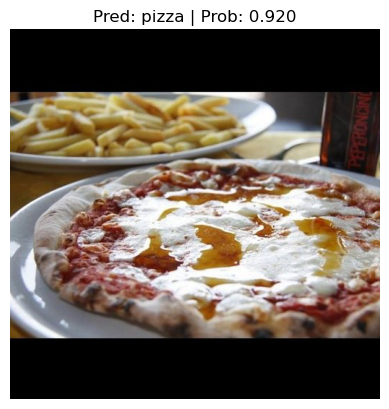

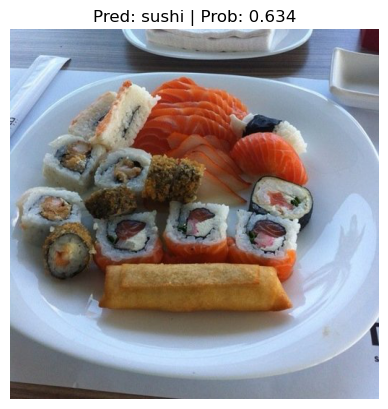

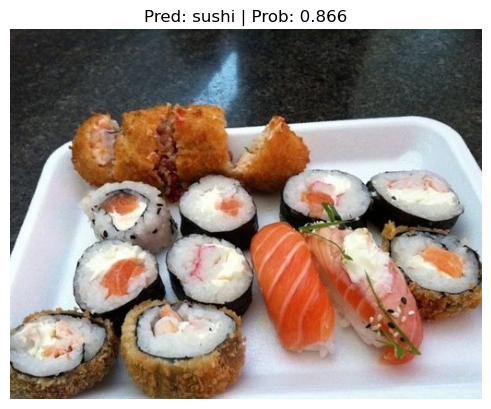

In [19]:
# Import function to make predictions on images and plot them 
# See the function previously created in section: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
from going_modular.going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path("data/pizza_steak_sushi_20_percent/test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

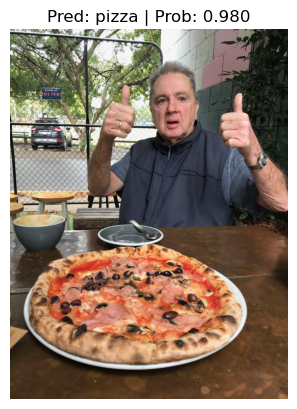

In [21]:
# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Predict on custom image
pred_and_plot_image(model=best_model,
                    image_path=custom_image_path,
                    class_names=class_names)